# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The business requirement here is to leverage used car sales data to better understand purchasing decisions of customers. We should examine all dimensions in the data to see which features have an impact in determining how much a customer will pay for a car.

We can use correlation and linear models to measure feature importance. Linear regression coefficients will suggest the magnitude of the relationship, and once we have this we can then inform the business on which levers they can manipulate to sell more cars or sell cars at a higher price. I will use a number of techniques in linear modeling to find the most accurate models (Sequential Feature Selection, Polynomial Features, Grid Search), and will apply regularization (L1, L2) if we want to limit the magnitude of coefficients.

If there are no obvious relationships in the data, we can try K-means clustering to try and identify similar pricing dynamics among certain groups of cars. If we have a large number of dimensions in the raw data, we can use PCA to reduce dimensionality while maintaining most of the variation in the data set.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. Examine all column and column types. Check how many missing values are in the data set.
2. How many unique values in each column? Are there ordinal string columns?
3. Are there levels to the data? Geographic, time, etc.
4. Chart data to view general trends and relationships (pairplot)
5. Make correlation matrix to see related fields

In [93]:
import pandas as pd
import seaborn as sns

In [94]:
def getPctMissing(df):
  return (df.isna().sum()/df.shape[0]*100).sort_values(ascending=False).round(1)

In [95]:
df = pd.read_csv('data/vehicles.csv')

In [96]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

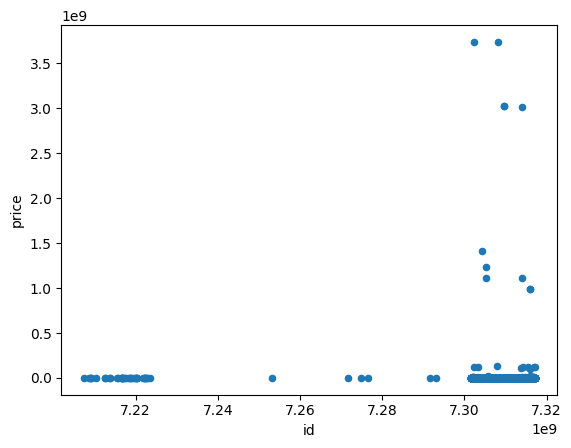

In [98]:
# drop id and VIN since these have no impact on price
df.plot(kind='scatter', x='id', y='price')
df = df.drop(columns=['id','VIN'])

<Axes: ylabel='Frequency'>

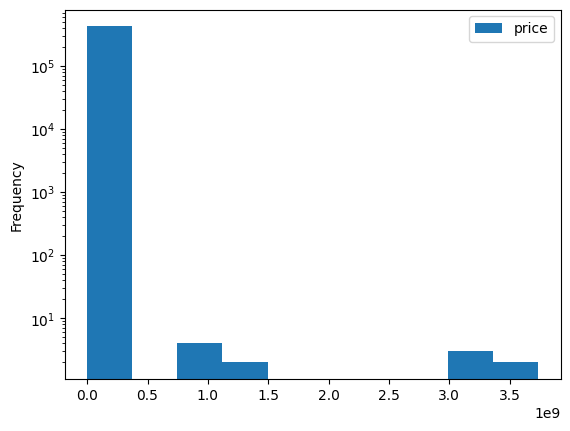

In [99]:
# Inspect distribution of price. Any outliers or strange trends?
# Use log scale to see the outliers around 3 and 1 e^9
df[['price']].plot(kind='hist', logy=True)

In [100]:
# There are outliers with prices of over $1b. Limiting to below $100k is reasonable
# given anything above that in this data set is extremely rare. Our model will not be good
# at predicting in that price region so I'd just limit training data to 100k.
df.query('price < 100000').sort_values('price', ascending=False).head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
77605,denver,99999,2015.0,jeep,wrangler unlimited rubicon,NaN,8 cylinders,gas,15944.0,clean,automatic,4wd,NaN,SUV,NaN,co
255553,north jersey,99999,2021.0,chevrolet,corvette,new,8 cylinders,gas,1.0,clean,automatic,rwd,NaN,NaN,black,nj
44134,palm springs,99999,1997.0,ferrari,f355 spider,excellent,8 cylinders,gas,22000.0,clean,manual,NaN,NaN,convertible,NaN,ca
44389,palm springs,99999,1997.0,ferrari,f355 spider,excellent,8 cylinders,gas,22000.0,clean,manual,NaN,NaN,convertible,NaN,ca
246133,scottsbluff / panhandle,99999,2020.0,ford,f-150 shelby edition,excellent,8 cylinders,gas,9600.0,clean,automatic,4wd,NaN,pickup,blue,ne


In [101]:
# almost 33k rows where price = 0, a minimum price of $1000 will probably drop a lot of incorrect data and is a reasonable minimum price of a pricing model
df.query('price < 1000').head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
10,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
11,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
12,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
13,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
14,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx


<Axes: ylabel='Frequency'>

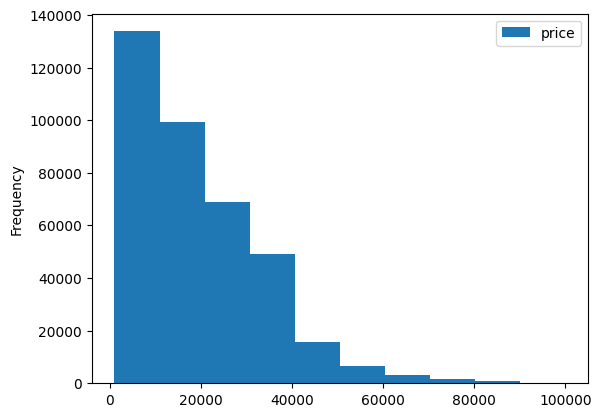

In [102]:
# This looks like a more reasonable price distribution. I think anything above
# $100k is more of a special sale and not something that needs to be modeled.
df[['price']].query('price < 100000 and price > 1000').plot(kind='hist')

In [103]:
# Limit data to between $1k and $100k
df = df.query('price >= 1000 and price <= 100000')

In [104]:
# Column % missing values
# Quite a few columns are over 20% null. For the others maybe we can drop rows
getPctMissing(df)

size            71.8
cylinders       40.8
condition       37.7
drive           30.3
paint_color     28.6
type            21.3
manufacturer     3.9
title_status     1.7
model            1.2
fuel             0.7
odometer         0.5
transmission     0.5
year             0.3
region           0.0
price            0.0
state            0.0
dtype: float64

In [105]:
# size is 72% missing, and the categories don't look informative anyway
# drop this column
df.groupby('size', dropna=False)['price'].mean()
df = df.drop(columns='size')

In [106]:
# cylinders is 41% missing. I checked a couple correlations and did
# not see anything we could use to impute missing values. Filling in
# a mean or some stat would create too much bias given it's 41% of the data.
df.value_counts('cylinders', dropna=False)
df = df.drop(columns='cylinders')

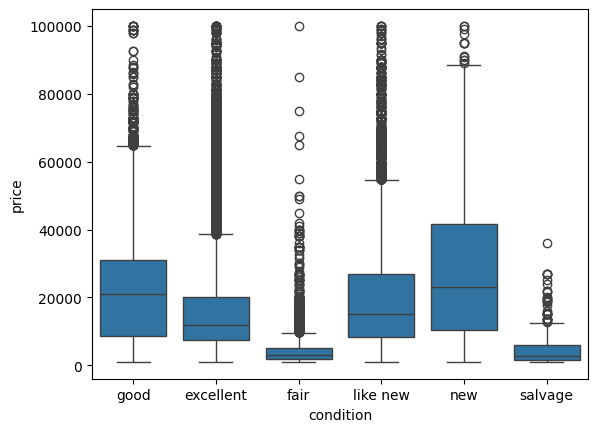

In [107]:
# The condition does not look like it has a strong effect on price. They are
# ordinal (from salvage to new) but the pricing is not linear. New, like new, good,
# and excellent are all very close in mean price. 

# Given this is 41% missing, I will drop this column
sns.boxplot(df, x='condition',y='price')
df = df.drop(columns='condition')

drive
4wd    115942
NaN    115013
fwd     94794
rwd     54161
Name: count, dtype: int64

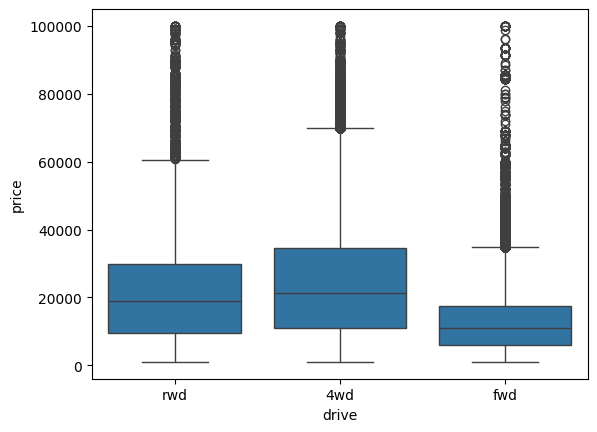

In [108]:
# drive is also largely 30% without a big trend on price. Dropping
display(df.value_counts('drive', dropna=False))
sns.boxplot(df, x='drive', y='price')
df = df.drop(columns='drive')

paint_color
NaN       108588
white      71528
black      57489
silver     39300
blue       28866
red        28332
grey       22269
green       6848
custom      6164
brown       6066
yellow      1991
orange      1815
purple       654
Name: count, dtype: int64

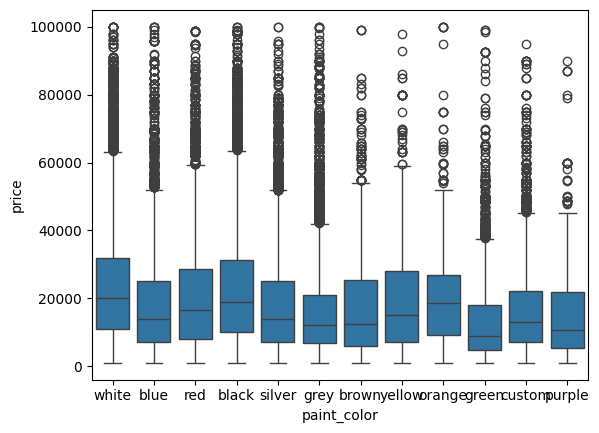

In [109]:
# paint_color is mostly missing and has a lot of values with small frequency
# like purple, organge, yellow. I don't think it's worth adding variation to the model
# predict prices of such rare colors.

# The prices are all similar each with many outliers. Dropping
display(df.value_counts('paint_color', dropna=False))
sns.boxplot(df, x='paint_color', y='price')
df = df.drop(columns='paint_color')

type
NaN            21.340054
sedan          20.375615
SUV            17.896607
pickup         10.807296
truck           7.754468
other           5.139902
coupe           4.621358
hatchback       4.094654
wagon           2.565871
van             2.054171
convertible     1.901240
mini-van        1.173962
offroad         0.153194
bus             0.121608
Name: count, dtype: float64

<Axes: xlabel='type', ylabel='price'>

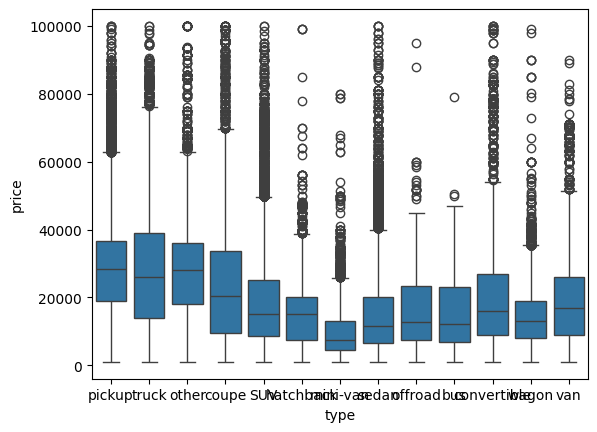

In [110]:
# There is some price variation explained by type, but there are a lot of outliers for
# each type. I think ultimately type will add noise to the model with so many outliers
# so I will drop it.
display(df.value_counts('type', dropna=False)/df.shape[0]*100)
display(sns.boxplot(df, x='type', y='price'))
df = df.drop(columns='type')

In [111]:
# There are no strong correlations to other columns, so imputing a type will be difficult.
# Given there is some pricing information
corr = pd.concat([df.select_dtypes('number'), pd.get_dummies(df['type'], dummy_na=True)*1]).corr()
corr.style.background_gradient(cmap='coolwarm')

KeyError: 'type'

In [ ]:
# remaining columns only largely non-null
getPctMissing(df)

manufacturer    3.9
title_status    1.7
model           1.2
fuel            0.7
odometer        0.5
transmission    0.5
year            0.3
region          0.0
price           0.0
state           0.0
dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379910 entries, 0 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        379910 non-null  object 
 1   price         379910 non-null  int64  
 2   year          378746 non-null  float64
 3   manufacturer  364940 non-null  object 
 4   model         375506 non-null  object 
 5   fuel          377319 non-null  object 
 6   odometer      377838 non-null  float64
 7   title_status  373352 non-null  object 
 8   transmission  378100 non-null  object 
 9   state         379910 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 31.9+ MB


<Axes: xlabel='price', ylabel='manufacturer'>

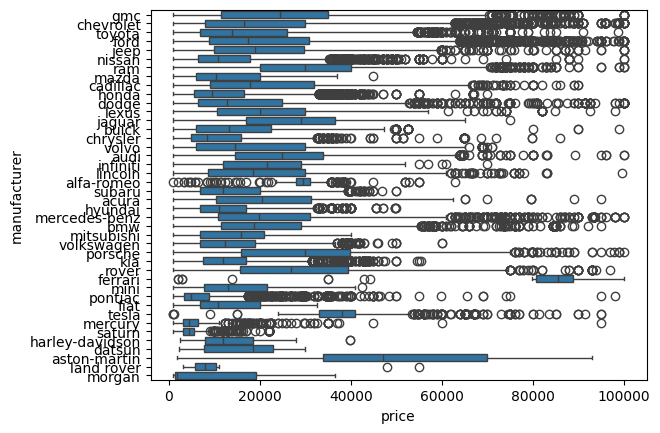

In [ ]:
# It looks like manufacturer can be important for some labels
df.value_counts('manufacturer', dropna=False)
sns.boxplot(df, y='manufacturer', x='price')

In [112]:
# data quality of rows with missing manufacturers is low,
# I'm dropping these rows from the data set.
display(df.query('manufacturer.isna()').head(10))
df = df.query('manufacturer.isna() == False')

In [113]:
getPctMissing(df)

title_status    1.7
model           1.2
fuel            0.6
odometer        0.5
transmission    0.5
year            0.0
region          0.0
price           0.0
manufacturer    0.0
state           0.0
dtype: float64

title_status
clean         346645
rebuilt         6779
salvage         3499
lien            1325
missing          499
parts only        89
Name: count, dtype: int64

/var/folders/83/256y9r4s4033nfv6c65pdpyh00hb_8/T/ipykernel_91950/2165193434.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna({'title_status': 'clean'}, inplace=True)


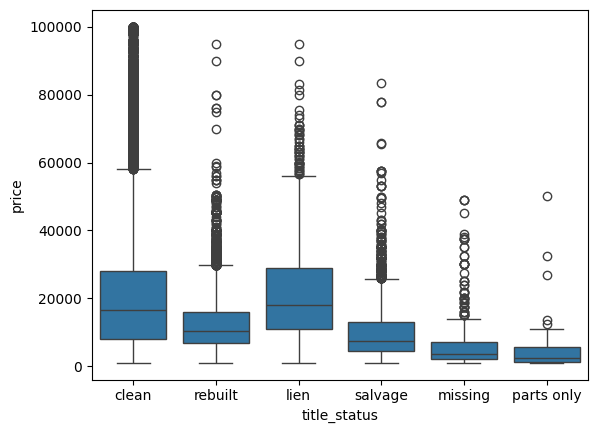

In [114]:
# has variation in price, I will keep title_status
# and impute the most frequent value for the missing values
display(df.value_counts('title_status'))
sns.boxplot(df, x='title_status', y='price')
df.fillna({'title_status': 'clean'}, inplace=True)


In [115]:
getPctMissing(df)

model           1.2
fuel            0.6
odometer        0.5
transmission    0.5
year            0.0
region          0.0
price           0.0
manufacturer    0.0
title_status    0.0
state           0.0
dtype: float64

21733

<Axes: xlabel='model'>

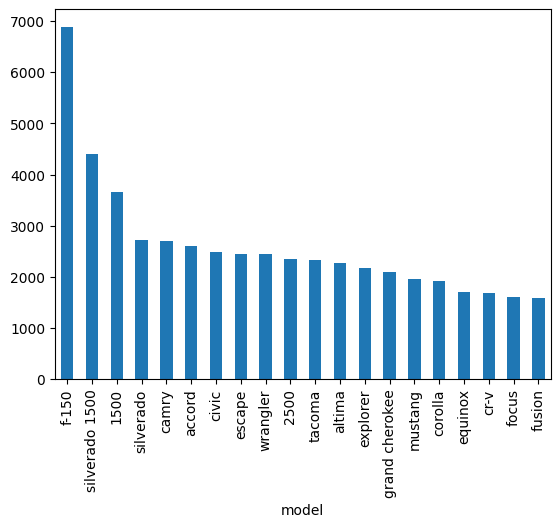

In [121]:
# 21k values in the model column, I don't think I want 21k dummy variables
# in the feature set
display(df.value_counts('model', dropna=False).shape[0])
df.value_counts('model').head(20).plot(kind='bar')

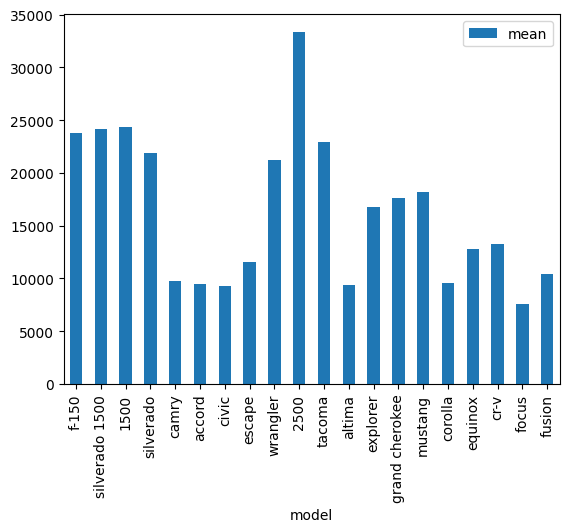

In [130]:
# Columns looks to be of low quality, too many messy values
# Dropping.
df.groupby('model')['price'].agg(['size','mean']).sort_values('size', ascending=False).head(20) \
  .reset_index().plot(kind='bar', x='model', y='mean')
df = df.drop(columns='model')

In [131]:
getPctMissing(df)

fuel            0.6
odometer        0.5
transmission    0.5
year            0.0
region          0.0
price           0.0
manufacturer    0.0
title_status    0.0
state           0.0
dtype: float64

fuel
gas         307932
other        26305
diesel       22345
hybrid        4691
electric      1501
Name: count, dtype: int64

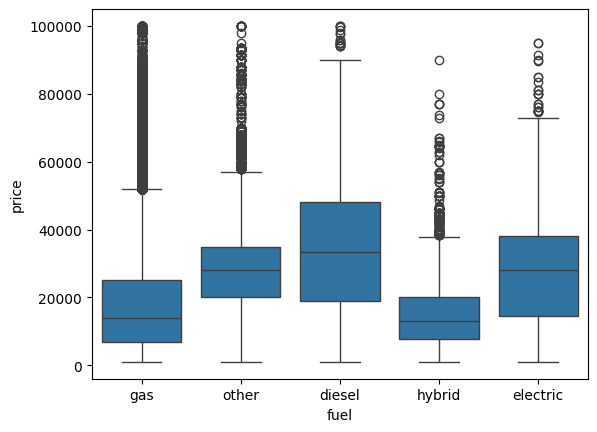

In [134]:
# Fair amount of variation across fuel types. Imputing most common value
# for NAs
display(df.value_counts('fuel'))
sns.boxplot(df, x='fuel', y='price')
df.fillna({'fuel':'gas'}, inplace=True)

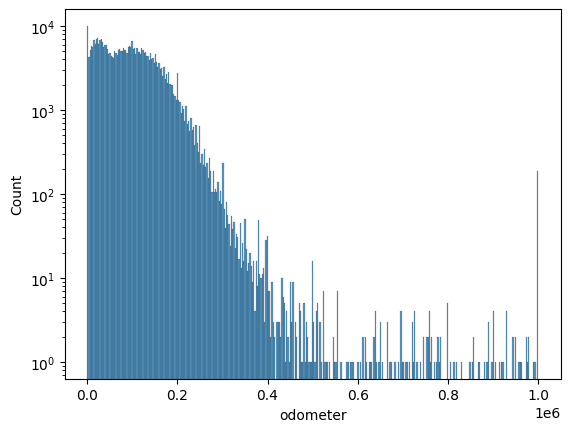

In [146]:
# Looks like there are a lot of extreme outliers above 4,000,000
# This shows poor data quality since the highest odometer reading ever recorded
# is 3m, and I'm sure even over 500k is extremely extremely rare. I will remove any
# records with odometer readings over 1m.
sns.histplot(df, x='odometer').set_yscale('log')
df = df.query('odometer < 500000 or odometer.isna()')

In [148]:
# impute median value for NAs
df.fillna({'odometer': df['odometer'].median()}, inplace=True)

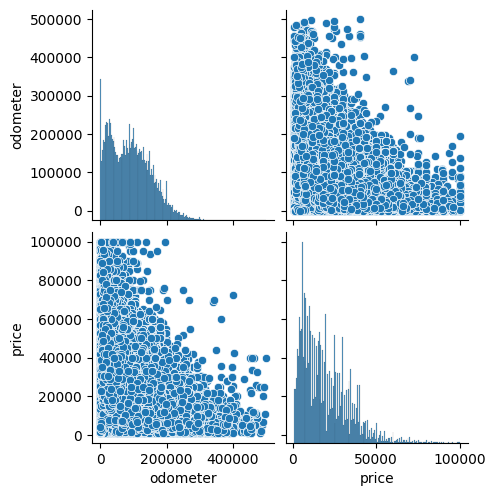

In [150]:
# There's a negative correlation with odometer, as expected
sns.pairplot(df[['odometer','price']])

transmission
automatic    283822
other         58529
manual        20192
NaN            1695
Name: count, dtype: int64

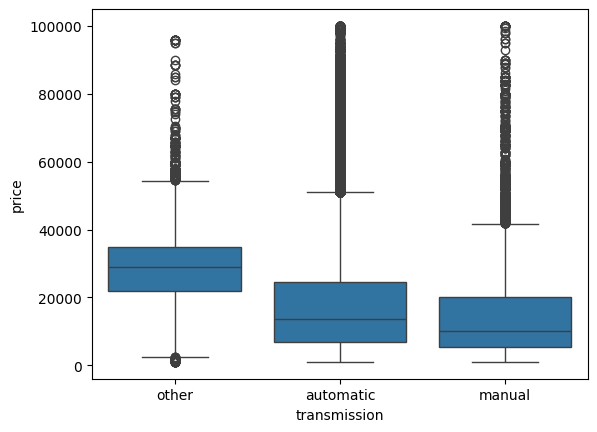

In [154]:
# Very few missing values in transmission, imputing most
# common value
display(df.value_counts('transmission', dropna=False))
sns.boxplot(df, x='transmission', y='price')
df.fillna({'transmission': 'automatic'}, inplace=True)

In [157]:
# Only 4 missing values remain in year. Just drop them.
display(df.isna().sum())
df = df.query('year.isna() == False')

In [179]:
# Looking at year, some years have very few rows. I will drop
# any year with fewer than 50 cars to reduce variance
yearsToDrop = df.value_counts('year').to_frame().query('count < 50').index.to_list()
df = df.query('year not in @yearsToDrop')

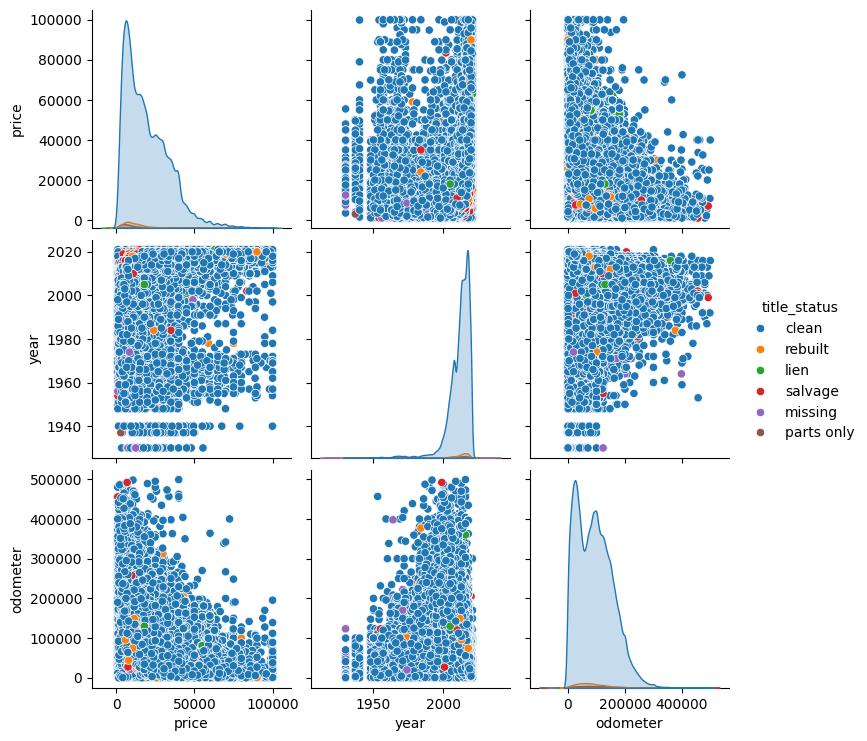

In [188]:
# pairplot of numeric values colord by title_status. nothing super interesting here.
sns.pairplot(df[['price', 'year', 'odometer','title_status']], hue='title_status')

region
columbus               3182
jacksonville           2942
grand rapids           2829
kansas city, MO        2762
nashville              2731
                       ... 
meridian                 16
southwest MS             12
kansas city               8
fort smith, AR            7
west virginia (old)       6
Name: count, Length: 404, dtype: int64

<Axes: >

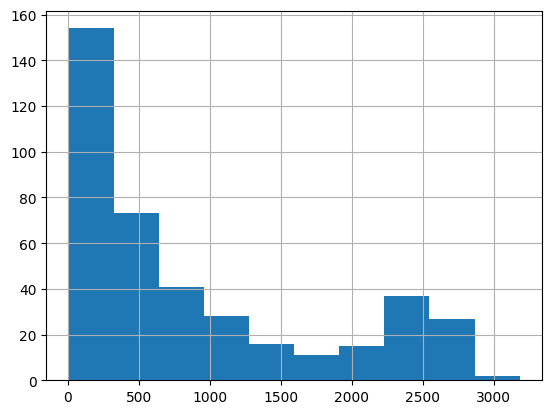

In [196]:
# 404 regions with bimodal distribution of counts
display(df.value_counts('region'))
df.value_counts('region').hist()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

I prefer to explore the data and prepare it at the same time. I progress through the data set cleaning it as I learn about it. All preparation has been done above based on my exploratory findings. This includes:
- Drop identification columns that are not related to price
- Dropping several columns that had high percentage of missing values. I did not see any obvious values to impute and randomly choosing one would have a significant impact on the data.
- Limit the range of some numeric columns by dropping extreme values with few row counts. For prediction, we are not likely to get such extreme values so we should not train the model on these values.
- For columns with some missing values, I imputed the median or the mode of the column.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [264]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector, VarianceThreshold
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer

In [191]:
# Setup training and test sets
trainX, testX, trainY, testY = train_test_split(df.drop(columns='price'), df['price'], train_size=0.7, random_state=420)

In [203]:
trainX.head()

,region,year,manufacturer,fuel,odometer,title_status,transmission,state
187217,boston,2004.0,ford,gas,182000.0,clean,automatic,ma
319280,medford-ashland,2005.0,honda,gas,160000.0,clean,automatic,or
357459,memphis,2014.0,chrysler,gas,129128.0,clean,automatic,tn
288118,akron / canton,2009.0,bmw,gas,98000.0,clean,automatic,oh
119467,treasure coast,2017.0,nissan,gas,13287.0,clean,automatic,fl


In [324]:
# Define pipeline
pipeline = Pipeline([
  ('preprocess', make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['region','manufacturer','fuel','title_status','transmission','state']),
    (PolynomialFeatures(degree=1, include_bias=False), ['year','odometer']))),
    # Need to use with_mean = False since sparse matrices are generated
  ('scale', StandardScaler(with_mean=False)),
  ('varFilter', VarianceThreshold(0.2)),
  # ('sfs', SequentialFeatureSelector(LinearRegression())),
  ('regression', LinearRegression())
])

# Hyperparameters to use in grid search
parameters = {
  'preprocess__polynomialfeatures__degree': [1],
  'sfs__n_features_to_select': [5],
  # 'sfs__lasso__alpha': [10**pp for pp in range(-1,2)]
}

# gridSearch = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')

In [325]:
pipeline.fit(trainX, trainY)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region', 'manufacturer',
                                                   'fuel', 'title_status',
                                                   'transmission', 'state']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  ['year', 'odometer'])])),
                ('scale', StandardScaler(with_mean=False)),
                ('varFilter', VarianceThreshold(threshold=0.2)),
                ('regression', LinearRegression())])

In [326]:
preds = pipeline.predict(testX)
mean_squared_error(testY, preds)

84977744.28477533

In [327]:
sum(pipeline.named_steps['varFilter'].get_support() == True)

512

In [329]:
pipeline.named_steps['sfs'].get_feature_names_out()

KeyError: 'sfs'

<Axes: xlabel='truth', ylabel='pred'>

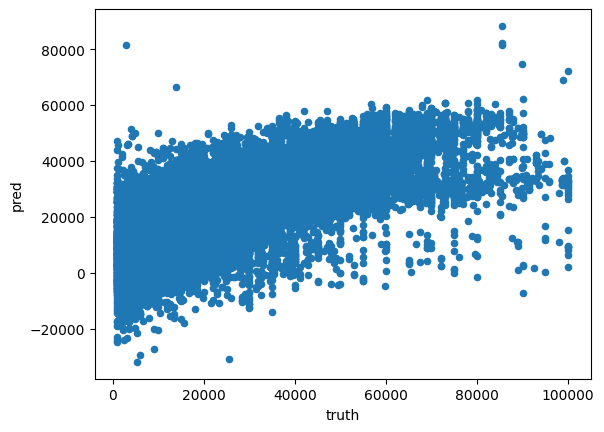

In [331]:
pd.DataFrame({'pred': preds, 'truth': testY}).plot.scatter(x='truth',y='pred')

In [330]:
pipeline.named_steps['preprocess'].get_feature_names_out()

array(['onehotencoder__region_SF bay area',
       'onehotencoder__region_abilene',
       'onehotencoder__region_akron / canton',
       'onehotencoder__region_albany',
       'onehotencoder__region_albuquerque',
       'onehotencoder__region_altoona-johnstown',
       'onehotencoder__region_amarillo', 'onehotencoder__region_ames',
       'onehotencoder__region_anchorage / mat-su',
       'onehotencoder__region_ann arbor',
       'onehotencoder__region_annapolis',
       'onehotencoder__region_appleton-oshkosh-FDL',
       'onehotencoder__region_asheville',
       'onehotencoder__region_ashtabula', 'onehotencoder__region_athens',
       'onehotencoder__region_atlanta', 'onehotencoder__region_auburn',
       'onehotencoder__region_augusta', 'onehotencoder__region_austin',
       'onehotencoder__region_bakersfield',
       'onehotencoder__region_baltimore',
       'onehotencoder__region_baton rouge',
       'onehotencoder__region_battle creek',
       'onehotencoder__region_beaumont / p

In [261]:
pi

In [ ]:

ohe = OneHotEncoder().fit_transform(trainX[['region']])OneHotEncoder().fit(trainX[['region']]).get_feature_names_out(['region'])
encoded = trainX[['region']].reset_index(drop=True).join(pd.DataFrame(ohe.toarray()))

In [223]:
gridSearch.fit(trainX, trainY)
cvResults = gridSearch.cv_results_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 370, in _score
 

KeyboardInterrupt: 

In [206]:
[10**pp for pp in range(-1,2)]

[0.1, 1, 10]

In [212]:
list(range(10,20)) + ['auto']

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'auto']

In [ ]:
# Training/Test set
# CV
# GridSearch
# SFS, Lasso Regression
# Standardize values, 

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.